Removing weight norm...


Conversion WAV → HiFi-GAN:   0%|          | 0/5 [00:00<?, ?it/s]

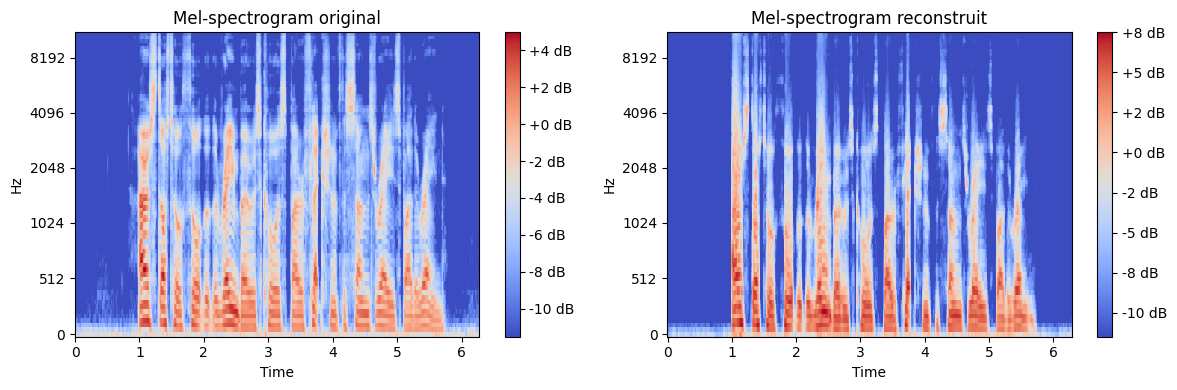

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

<Figure size 640x480 with 0 Axes>

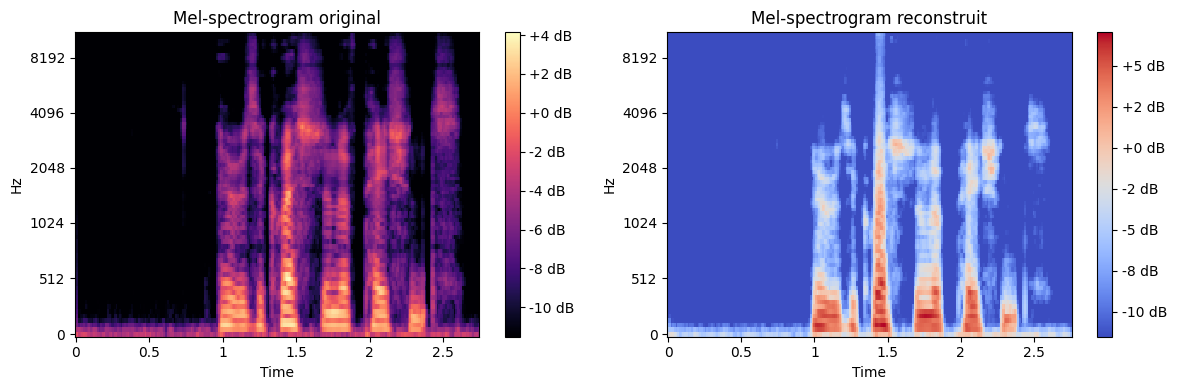

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  40%|████      | 2/5 [00:00<00:01,  2.27it/s]

<Figure size 640x480 with 0 Axes>

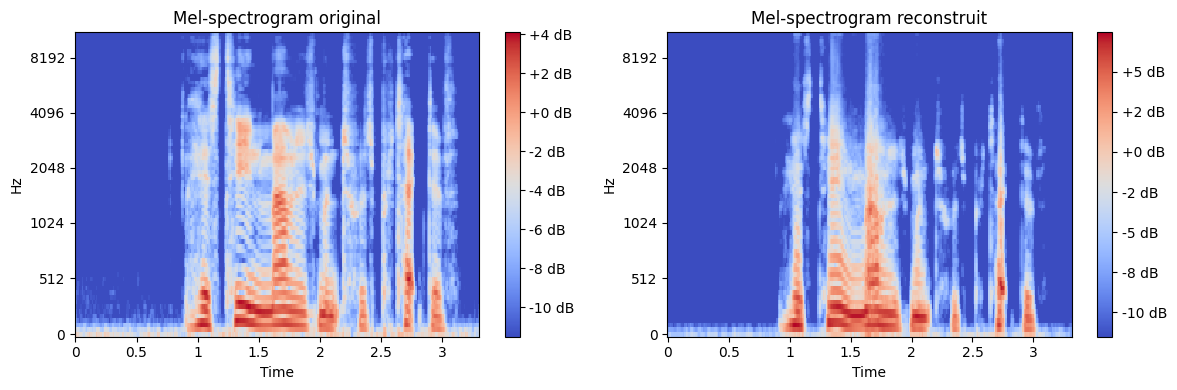

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  60%|██████    | 3/5 [00:01<00:00,  2.56it/s]

<Figure size 640x480 with 0 Axes>

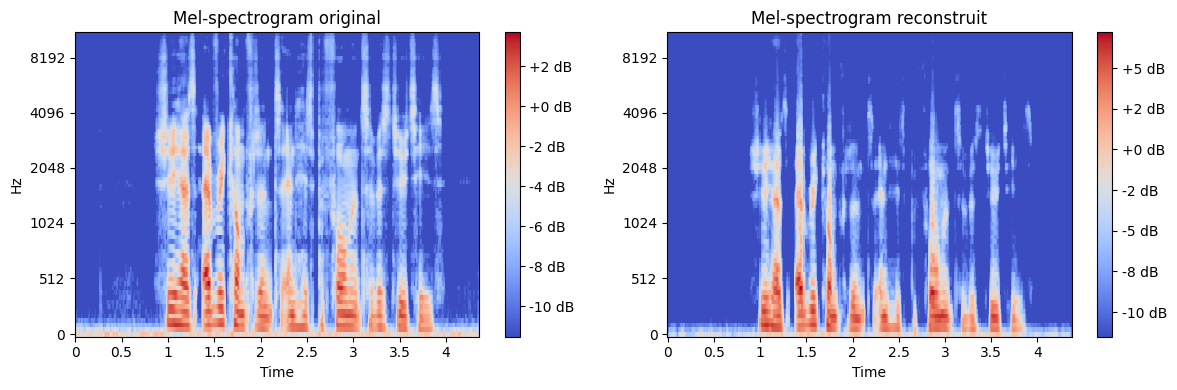

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  80%|████████  | 4/5 [00:01<00:00,  2.57it/s]

<Figure size 640x480 with 0 Axes>

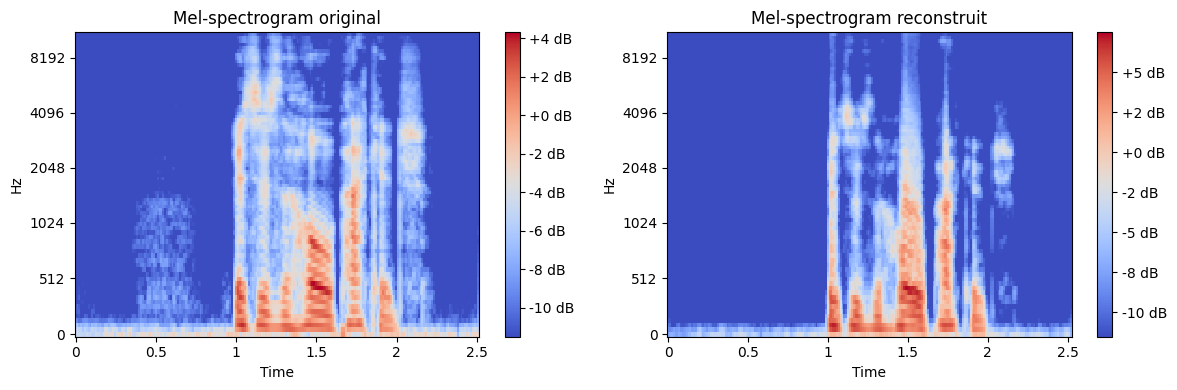

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

✅ Tous les fichiers WAV reconstruits et visualisés dans /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/outputs_hifigan


<Figure size 640x480 with 0 Axes>

In [17]:
# ================================================================
# HiFi-GAN : Visualisation et comparaison Mel-Spectrogram
# Avec lecture audio originale et reconstruite
# ================================================================

import os
import sys
import json
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
from IPython.display import Audio, display
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
# ------------------------------------------------
# 1️⃣ Chemins du modèle
# ------------------------------------------------
# Chemin vers le dossier contenant HiFi-GAN
hifi_path = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/hifi-gan"
sys.path.append(hifi_path)

MODEL_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/hifi-gan"
GEN_PATH = os.path.join(MODEL_DIR, "generator_v1")
CFG_PATH = os.path.join(MODEL_DIR, "config_v1.json")
assert os.path.exists(GEN_PATH), f"❌ {GEN_PATH} manquant"
assert os.path.exists(CFG_PATH), f"❌ {CFG_PATH} manquant"
"""
- GEN_PATH → fichier des poids du modèle pré-entraîné.
- CFG_PATH → fichier de configuration, contient tous les hyperparamètres : 
nombre de couches, filtres, kernels…
- assert → vérifie que les fichiers existent pour éviter des erreurs plus loin.
- Point clé : le modèle et la config doivent correspondre exactement à la version 
du générateur (v1, v2 ou v3).
"""
# ------------------------------------------------
# Clonage HiFi-GAN
# ------------------------------------------------
from models import Generator
from env import AttrDict
"""
- Generator → classe définissant le vocodeur neural.
- AttrDict → transforme un dictionnaire en objet avec attributs 
(h.resblock_kernel_sizes etc.), ce que le modèle attend.
- distinction entre architecture du modèle et poids pré-entraînés.
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
"""
- Vérifie si un GPU est disponible, sinon utilise le CPU.
- Important pour accélérer le calcul, car HiFi-GAN est lourd.
"""
# ------------------------------------------------
# 3️⃣ Charger le modèle HiFi-GAN
# ------------------------------------------------

def load_hifigan_model(checkpoint=GEN_PATH, config=CFG_PATH, device=device):
    with open(config, "r") as f:
        cfg = json.load(f)
    h = AttrDict(cfg)
    model = Generator(h)
    state = torch.load(checkpoint, map_location=device)
    model.load_state_dict(state["generator"])
    model.eval()
    model.remove_weight_norm()
    model = model.to(device)
    return model
"""
- Lire le fichier de configuration JSON → dictionnaire Python → AttrDict.
- Créer le modèle HiFi-GAN (Generator(h)).
- Charger les poids pré-entraînés (state["generator"]).
- Mettre le modèle en mode évaluation (.eval()) → désactive dropout, batchnorm etc.
- Supprimer la normalisation des poids (remove_weight_norm) → nécessaire pour l’inférence.
- Envoyer le modèle sur le device choisi (GPU ou CPU).
**distinction entre architecture et poids, et importance du mode évaluation pour l’inférence.
"""
hifigan = load_hifigan_model()

# ------------------------------------------------
# 4️⃣ Fonction : WAV → Mel float
# ------------------------------------------------
def wav_to_mel(path, sr=22050, n_fft=1024, hop_length=256, n_mels=80):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel = np.log(np.clip(mel, a_min=1e-5, a_max=None))  # log-mel
    mel_tensor = torch.tensor(mel).unsqueeze(0).to(device)  # [1, 80, T]
    return mel_tensor, mel, y
"""
- librosa.load → lit le fichier WAV et le normalise entre -1 et 1.
- melspectrogram → convertit le signal en représentation temps-fréquence (80 bandes mel).
- log → compressé pour correspondre à la perception humaine et à l’entrainement HiFi-GAN.
- np.clip(mel, a_min=1e-5, a_max=None)
    Objectif : éviter les valeurs trop petites ou nulles dans le spectrogramme.
- np.clip limite les valeurs de mel :
    Toute valeur < 1e-5 devient 1e-5.
    a_max=None signifie qu'on ne fixe pas de maximum.
    Pourquoi ? Parce que le logarithme d'une valeur proche de zéro ou négative est 
    mathématiquement invalide ou très grand en négatif.
- np.log(...): On applique le logarithme naturel à chaque valeur du spectrogramme.
    Cela transforme le spectrogramme en log-melspectrogramme, ce qui est plus proche de la 
    perception humaine du son (car notre oreille perçoit les intensités de manière 
    logarithmique).
- torch.tensor(mel).unsqueeze(0).to(device)
    - torch.tensor(mel) : conversion du tableau NumPy en tenseur PyTorch.
    -.unsqueeze(0) : ajoute une dimension en début (batch size = 1).
    Si mel est de forme [80, T], alors mel_tensor devient [1, 80, T].
    T = le nombre de frames temporelles: Chaque colonne du melspectrogramme 
    correspond à un instant dans le temps.
    Donc T est la durée du signal audio exprimée en tranches temporelles (ou "frames").
    Plus T est grand, plus le spectrogramme couvre une longue durée audio.
    Dimensions typiques du melspectrogramme : [1, 80, T] :
        1 : batch size (on traite un seul exemple à la fois)
        80 : nombre de bandes de fréquences (souvent 80 mels)
        T : nombre de tranches temporelles (variable selon la durée du signal)
    -.to(device) : envoie le tenseur sur le GPU ou CPU selon device.
    
** HiFi-GAN travaille sur mel float, pas sur des images ou spectrogrammes en PNG.
** Cette transformation est essentielle pour préparer un melspectrogramme en entrée 
d’un modèle comme HiFi-GAN, qui attend un tenseur de forme [batch_size, n_mel_channels, time].
"""
# ------------------------------------------------
# 5️⃣ Batch processing WAV avec visualisation
# ------------------------------------------------
INPUT_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/train"
OUTPUT_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/outputs_hifigan"
os.makedirs(OUTPUT_DIR, exist_ok=True)

wav_files = [f for f in os.listdir(INPUT_DIR) if f.endswith(".wav")]
part_of_wav_files = wav_files[:5]
for file in tqdm(part_of_wav_files, desc="Conversion WAV → HiFi-GAN"):
    wav_path = os.path.join(INPUT_DIR, file)
    
    # 🔹 Conversion en mel
    mel_tensor, mel_orig, y_orig = wav_to_mel(wav_path)
    
    # 🔹 Génération audio avec HiFi-GAN
    """
    - torch.no_grad() → pas de calcul de gradient pour économiser mémoire.
    - squeeze() → supprime la dimension batch [1, T] → [T].
    - Normalisation pour éviter clipping audio.
    - Sauvegarde le WAV reconstruit pour écoute et analyse.
    """
    with torch.no_grad():
        audio = hifigan(mel_tensor).cpu().squeeze().numpy()
    
    # 🔹 Normalisation audio
    audio = audio / np.max(np.abs(audio) + 1e-9)
    
    # 🔹 Sauvegarde reconstruction
    out_path = os.path.join(OUTPUT_DIR, file)
    sf.write(out_path, audio, 22050)
    
    # 🔹 Calcul du mel reconstruit
    mel_rec = librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=1024, hop_length=256, n_mels=80)
    mel_rec = np.log(np.clip(mel_rec, 1e-5, None))
    
    # 🔹 Affichage des mel-spectrograms côte à côte
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    librosa.display.specshow(mel_orig, sr=22050, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-spectrogram original")
    
    plt.subplot(1,2,2)
    librosa.display.specshow(mel_rec, sr=22050, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-spectrogram reconstruit")
    
    plt.tight_layout()
    plt.show()
    plt.clf() # Clears the current figure
    
    # 🔹 Audio player : original et reconstruit
    print("🎵 Audio original :")
    display(Audio(y_orig, rate=22050))
    
    print("🎵 Audio reconstruit HiFi-GAN :")
    display(Audio(audio, rate=22050))

print(f"✅ Tous les fichiers WAV reconstruits et visualisés dans {OUTPUT_DIR}")


In [3]:
"""
prepare_wavs.py - Audio Preprocessing
Trims silences and normalizes audio files
"""

import os
import glob
import librosa
import soundfile as sf
import numpy as np
from tqdm import tqdm

SR = 22050

def fix_file(in_path, out_path):
    """
    Load, trim silence, and normalize audio file
    
    Args:
        in_path: input wav file path
        out_path: output wav file path
    """
    # Load audio
    y, sr = librosa.load(in_path, sr=SR, mono=True)
    
    # Trim silences (30dB threshold)
    yt, _ = librosa.effects.trim(y, top_db=30)
    
    # Normalize RMS to -20 dBFS (target_rms = 0.1)
    rms = np.sqrt(np.mean(yt**2))
    target_rms = 0.1
    if rms > 1e-8:
        yt = yt * (target_rms / rms)
    
    # Ensure no clipping
    yt = np.clip(yt, -1.0, 1.0)
    
    # Save as 16-bit PCM
    sf.write(out_path, yt, SR, subtype='PCM_16')

def process_folder(src_folder, dst_folder):
    """
    Process all wav files in a folder
    
    Args:
        src_folder: source directory with raw wav files
        dst_folder: destination directory for processed files
    """
    os.makedirs(dst_folder, exist_ok=True)
    
    wav_files = sorted(glob.glob(os.path.join(src_folder, '*.wav')))
    
    if not wav_files:
        print(f"⚠️  No wav files found in {src_folder}")
        return
    
    print(f"Processing {len(wav_files)} files from {src_folder}")
    
    for p in tqdm(wav_files, desc=f"Processing {os.path.basename(src_folder)}"):
        fname = os.path.basename(p)
        try:
            fix_file(p, os.path.join(dst_folder, fname))
        except Exception as e:
            print(f"❌ Error processing {fname}: {e}")

if __name__ == "__main__":
    # Update these paths to your data directories
    BASE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2'
    
    # Process speaker A
    process_folder(
        os.path.join(BASE_DIR, 'speaker_A/train'),
        os.path.join(BASE_DIR, 'speaker_A/processed')
    )
    
    # Process speaker B
    process_folder(
        os.path.join(BASE_DIR, 'speaker_B/train'),
        os.path.join(BASE_DIR, 'speaker_B/processed')
    )
    
    print("✅ Audio preprocessing complete!")

Processing 215 files from /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/train


Processing train: 100%|██████████| 215/215 [00:01<00:00, 151.77it/s]


Processing 215 files from /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/train


Processing train: 100%|██████████| 215/215 [00:00<00:00, 215.97it/s]

✅ Audio preprocessing complete!


In [4]:
"""
fe.py - Feature Extraction (Fixed)
Extracts mel-spectrograms with correct parameters for HiFi-GAN
"""

import os
import glob
import numpy as np
import librosa
from tqdm import tqdm

# Audio parameters (must match HiFi-GAN config)
SR = 22050
N_FFT = 1024
HOP = 256
WIN = 1024
N_MELS = 80
FMIN = 0
FMAX = 8000

def wav_to_mel(path):
    """
    Convert wav file to log mel-spectrogram
    
    Args:
        path: path to wav file
    
    Returns:
        mel: log mel-spectrogram (n_mels, T) as float32
    """
    # Load audio
    y, sr = librosa.load(path, sr=SR, mono=True)
    
    # Extract mel-spectrogram with POWER=2.0 (critical fix!)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP,
        win_length=WIN,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX,
        power=2.0  # ← FIXED: Use power spectrogram (was 1.0)
    )
    
    # Convert to log scale with proper clipping
    mel = np.log(np.clip(S, 1e-9, None))
    
    return mel.astype(np.float32)

def process_folder(in_dir, out_dir):
    """
    Extract mel-spectrograms for all wav files in directory
    
    Args:
        in_dir: input directory with processed wav files
        out_dir: output directory for mel .npy files
    """
    os.makedirs(out_dir, exist_ok=True)
    
    wav_files = sorted(glob.glob(os.path.join(in_dir, '*.wav')))
    
    if not wav_files:
        print(f"⚠️  No wav files found in {in_dir}")
        return
    
    print(f"Extracting mel-spectrograms from {len(wav_files)} files")
    
    for p in tqdm(wav_files, desc=f"Extracting {os.path.basename(in_dir)}"):
        try:
            mel = wav_to_mel(p)
            fname = os.path.splitext(os.path.basename(p))[0] + '.npy'
            np.save(os.path.join(out_dir, fname), mel)
        except Exception as e:
            print(f"❌ Error processing {os.path.basename(p)}: {e}")

if __name__ == "__main__":
    # Update these paths
    BASE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2'
    
    # Extract features for speaker A
    process_folder(
        os.path.join(BASE_DIR, 'speaker_A/processed'),
        os.path.join(BASE_DIR, 'speaker_A/mels')
    )
    
    # Extract features for speaker B
    process_folder(
        os.path.join(BASE_DIR, 'speaker_B/processed'),
        os.path.join(BASE_DIR, 'speaker_B/mels')
    )
    
    print("✅ Feature extraction complete!")

Extracting mel-spectrograms from 215 files


Extracting processed: 100%|██████████| 215/215 [00:01<00:00, 142.68it/s]


Extracting mel-spectrograms from 215 files


Extracting processed: 100%|██████████| 215/215 [00:01<00:00, 119.73it/s]

✅ Feature extraction complete!


In [5]:
"""
align.py - DTW Alignment
Aligns mel-spectrograms from speaker A and B using Dynamic Time Warping
"""

import numpy as np
import glob
import os
import librosa
from tqdm import tqdm
from scipy.spatial.distance import cdist

def align_pair(melA, melB):
    """
    Align two mel-spectrograms using DTW
    
    Args:
        melA: mel-spectrogram of speaker A (n_mels, T_a)
        melB: mel-spectrogram of speaker B (n_mels, T_b)
    
    Returns:
        aligned_A: aligned mel-spectrogram A (n_mels, T_aligned)
        aligned_B: aligned mel-spectrogram B (n_mels, T_aligned)
    """
    # Compute cosine distance matrix
    D = cdist(melA.T, melB.T, metric='cosine')  # shape (T_a, T_b)
    
    # Perform DTW
    D_acc, wp = librosa.sequence.dtw(C=D, backtrack=True)
    
    # Extract alignment path
    pathA = wp[:, 0].astype(int)
    pathB = wp[:, 1].astype(int)
    
    # Align spectrograms
    aligned_A = melA[:, pathA]
    aligned_B = melB[:, pathB]
    
    return aligned_A, aligned_B

def find_matching_file(a_file, b_files, b_dir, b_suffix_map):
    """
    Find matching file from speaker B for a given speaker A file
    
    Returns:
        matched file path or None
    """
    base = os.path.basename(a_file)
    
    # 1) Try exact match
    b_file = os.path.join(b_dir, base)
    if os.path.exists(b_file):
        return b_file
    
    # 2) Try suffix match (e.g., p225_001_mic1.npy <-> p226_001_mic1.npy)
    suffix = base.split('_', 1)[1] if '_' in base else base
    if suffix in b_suffix_map:
        return b_suffix_map[suffix][0]
    
    # 3) Fallback: search any file ending with same suffix
    candidates = [p for p in b_files if p.endswith(suffix)]
    if candidates:
        return candidates[0]
    
    return None

if __name__ == "__main__":
    # Setup directories
    BASE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2'
    
    a_dir = os.path.join(BASE_DIR, 'speaker_A/mels')
    b_dir = os.path.join(BASE_DIR, 'speaker_B/mels')
    
    OUT_A = os.path.join(BASE_DIR, 'speaker_A/aligned')
    OUT_B = os.path.join(BASE_DIR, 'speaker_B/aligned')
    
    os.makedirs(OUT_A, exist_ok=True)
    os.makedirs(OUT_B, exist_ok=True)
    
    # Load file lists
    a_files = sorted(glob.glob(os.path.join(a_dir, '*.npy')))
    b_files = sorted(glob.glob(os.path.join(b_dir, '*.npy')))
    
    print(f"Found {len(a_files)} files in speaker_A/mels")
    print(f"Found {len(b_files)} files in speaker_B/mels")
    
    if not a_files or not b_files:
        print("❌ Error: No mel files found. Run fe.py first!")
        exit(1)
    
    # Build suffix map for B files
    b_suffix_map = {}
    for p in b_files:
        name = os.path.basename(p)
        suffix = name.split('_', 1)[1] if '_' in name else name
        b_suffix_map.setdefault(suffix, []).append(p)
    
    # Process alignments
    saved = 0
    skipped = 0
    
    print("\nAligning mel-spectrograms...")
    for a_file in tqdm(a_files):
        base = os.path.basename(a_file)
        
        # Find matching B file
        matched = find_matching_file(a_file, b_files, b_dir, b_suffix_map)
        
        if matched is None:
            tqdm.write(f"⚠️  {base} -> No partner found, skipping")
            skipped += 1
            continue
        
        try:
            # Load mel-spectrograms
            melA = np.load(a_file)
            melB = np.load(matched)
            
            # Align using DTW
            a_al, b_al = align_pair(melA, melB)
            
            # Save aligned spectrograms
            out_a_path = os.path.join(OUT_A, base)
            out_b_path = os.path.join(OUT_B, os.path.basename(matched))
            
            np.save(out_a_path, a_al)
            np.save(out_b_path, b_al)
            
            saved += 1
            
        except Exception as e:
            tqdm.write(f"❌ Error processing {base}: {e}")
            skipped += 1
    
    print(f"\n✅ Alignment complete!")
    print(f"   Saved: {saved} pairs")
    print(f"   Skipped: {skipped} files")

Found 215 files in speaker_A/mels
Found 215 files in speaker_B/mels

Aligning mel-spectrograms...


100%|██████████| 215/215 [00:00<00:00, 361.79it/s]


✅ Alignment complete!
   Saved: 215 pairs
   Skipped: 0 files


In [18]:
# model_gan.py - Enhanced Mel Mapper with Discriminator
import torch
import torch.nn as nn

class ResConvBlock(nn.Module):
    def __init__(self, ch, ks=5, dilation=1):
        super().__init__()
        pad = (ks - 1) // 2 * dilation
        self.conv = nn.Sequential(
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch, ch, kernel_size=ks, padding=pad, dilation=dilation),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch, ch, kernel_size=1)
        )
    
    def forward(self, x):
        return x + self.conv(x)


class MelMapper(nn.Module):
    """Generator: Maps source mel to target mel"""
    def __init__(self, n_mels=80, hidden=512):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv1d(n_mels, hidden, kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
        )
        # 6 residual blocks with increasing dilation
        dilations = [1, 2, 4, 1, 2, 4]
        self.resblocks = nn.Sequential(*[
            ResConvBlock(hidden, ks=5, dilation=d) for d in dilations
        ])
        # Decoder
        self.dec = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden, n_mels, kernel_size=1)
        )
    
    def forward(self, m):
        h = self.enc(m)
        h = self.resblocks(h)
        out = self.dec(h)
        return out


class MelDiscriminator(nn.Module):
    """
    PatchGAN-style discriminator for mel-spectrograms.
    Classifies overlapping patches as real/fake.
    """
    def __init__(self, n_mels=80, hidden=64):
        super().__init__()
        
        # Convolutional layers with increasing channels
        self.layers = nn.ModuleList([
            # Layer 1: 80 -> 64
            nn.Sequential(
                nn.Conv1d(n_mels, hidden, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(0.2, inplace=True)
            ),
            # Layer 2: 64 -> 128
            nn.Sequential(
                nn.Conv1d(hidden, hidden*2, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm1d(hidden*2),
                nn.LeakyReLU(0.2, inplace=True)
            ),
            # Layer 3: 128 -> 256
            nn.Sequential(
                nn.Conv1d(hidden*2, hidden*4, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm1d(hidden*4),
                nn.LeakyReLU(0.2, inplace=True)
            ),
            # Layer 4: 256 -> 512
            nn.Sequential(
                nn.Conv1d(hidden*4, hidden*8, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm1d(hidden*8),
                nn.LeakyReLU(0.2, inplace=True)
            ),
        ])
        
        # Final layer: 512 -> 1 (real/fake classification)
        self.final = nn.Conv1d(hidden*8, 1, kernel_size=3, padding=1)
    
    def forward(self, mel):
        """
        mel: [B, n_mels, T] - input mel-spectrogram
        returns: [B, 1, T//16] - patch-wise predictions
        """
        x = mel
        for layer in self.layers:
            x = layer(x)
        out = self.final(x)
        return out


# Multi-scale discriminator (optional but recommended)
class MultiScaleDiscriminator(nn.Module):
    """
    Uses 3 discriminators at different scales for better quality.
    This helps capture both fine details and global structure.
    """
    def __init__(self, n_mels=80):
        super().__init__()
        self.disc1 = MelDiscriminator(n_mels, hidden=64)
        self.disc2 = MelDiscriminator(n_mels, hidden=64)
        self.disc3 = MelDiscriminator(n_mels, hidden=64)
        
        # Downsampling for multi-scale
        self.downsample = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)
    
    def forward(self, mel):
        """
        Returns predictions from 3 scales
        """
        # Scale 1: original resolution
        out1 = self.disc1(mel)
        
        # Scale 2: 2x downsampled
        mel2 = self.downsample(mel)
        out2 = self.disc2(mel2)
        
        # Scale 3: 4x downsampled
        mel3 = self.downsample(mel2)
        out3 = self.disc3(mel3)
        
        return [out1, out2, out3]


# Perceptual loss using pre-extracted features (optional enhancement)
class FeatureMatchingLoss(nn.Module):
    """
    Computes L1 loss between intermediate discriminator features.
    Helps generator produce more realistic spectrograms.
    """
    def __init__(self):
        super().__init__()
        self.criterion = nn.L1Loss()
    
    def forward(self, fake_features, real_features):
        loss = 0
        for fake_feat, real_feat in zip(fake_features, real_features):
            loss += self.criterion(fake_feat, real_feat)
        return loss


if __name__ == "__main__":
    # Test the models
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Test Generator
    generator = MelMapper(n_mels=80, hidden=512).to(device)
    test_mel = torch.randn(4, 80, 256).to(device)
    output = generator(test_mel)
    print(f"Generator output shape: {output.shape}")  # Should be [4, 80, 256]
    
    # Test Discriminator
    discriminator = MelDiscriminator(n_mels=80, hidden=64).to(device)
    disc_output = discriminator(output)
    print(f"Discriminator output shape: {disc_output.shape}")  # Should be [4, 1, T//16]
    
    # Test Multi-scale Discriminator
    ms_discriminator = MultiScaleDiscriminator(n_mels=80).to(device)
    ms_outputs = ms_discriminator(output)
    print(f"Multi-scale discriminator outputs: {[o.shape for o in ms_outputs]}")
    
    # Count parameters
    gen_params = sum(p.numel() for p in generator.parameters())
    disc_params = sum(p.numel() for p in discriminator.parameters())
    print(f"\nGenerator parameters: {gen_params:,}")
    print(f"Discriminator parameters: {disc_params:,}")

Generator output shape: torch.Size([4, 80, 256])
Discriminator output shape: torch.Size([4, 1, 16])
Multi-scale discriminator outputs: [torch.Size([4, 1, 16]), torch.Size([4, 1, 8]), torch.Size([4, 1, 4])]

Generator parameters: 9,704,016
Discriminator parameters: 890,049


In [19]:
# train_gan.py - Training script with GAN losses
import torch
import torch.nn as nn
import glob
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os

# Dataset (same as before)
class MelDataset(Dataset):
    def __init__(self, folderA, folderB, crop=128):
        a_files = sorted(glob.glob(os.path.join(folderA, '*.npy')))
        b_files = sorted(glob.glob(os.path.join(folderB, '*.npy')))
        
        b_map = {}
        for p in b_files:
            name = os.path.basename(p)
            suffix = name.split('_', 1)[1] if '_' in name else name
            b_map.setdefault(suffix, []).append(p)
        
        pairs = []
        missed = []
        for a in a_files:
            a_name = os.path.basename(a)
            b_candidate = os.path.join(folderB, a_name)
            matched = None
            if os.path.exists(b_candidate):
                matched = b_candidate
            else:
                suffix = a_name.split('_', 1)[1] if '_' in a_name else a_name
                if suffix in b_map:
                    matched = b_map[suffix][0]
                else:
                    cand = [p for p in b_files if p.endswith(suffix)]
                    if cand:
                        matched = cand[0]
            if matched:
                pairs.append((a, matched))
            else:
                missed.append(a_name)
        
        if missed:
            print(f"MelDataset: {len(missed)} A files have no partner. Examples: {missed[:5]}")
        
        self.pairs = pairs
        self.crop = crop
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        a_path, b_path = self.pairs[idx]
        a = np.load(a_path)
        b = np.load(b_path)
        Ta = a.shape[1]; Tb = b.shape[1]
        T_min = min(Ta, Tb)
        
        if T_min > self.crop:
            s = np.random.randint(0, T_min - self.crop + 1)
            a = a[:, s:s+self.crop]
            b = b[:, s:s+self.crop]
        else:
            def pad_to_crop(m, crop):
                if m.shape[1] >= crop:
                    return m[:, :crop]
                pad_len = crop - m.shape[1]
                return np.pad(m, ((0,0),(0,pad_len)), mode='constant', constant_values=0.0)
            a = pad_to_crop(a, self.crop)
            b = pad_to_crop(b, self.crop)
        
        return torch.from_numpy(a).float(), torch.from_numpy(b).float()


# GAN Loss Functions
def discriminator_loss(real_preds, fake_preds):
    """
    Hinge loss for discriminator:
    - Maximize real_preds (want them > 0)
    - Minimize fake_preds (want them < 0)
    """
    loss_real = torch.mean(torch.relu(1.0 - real_preds))
    loss_fake = torch.mean(torch.relu(1.0 + fake_preds))
    return loss_real + loss_fake


def generator_adversarial_loss(fake_preds):
    """
    Hinge loss for generator:
    - Maximize fake_preds (want discriminator to think they're real)
    """
    return -torch.mean(fake_preds)


def multi_scale_discriminator_loss(discriminator, real_mels, fake_mels):
    """
    Computes discriminator loss across multiple scales
    """
    real_outputs = discriminator(real_mels)
    fake_outputs = discriminator(fake_mels.detach())  # detach to not train generator
    
    total_loss = 0
    for real_pred, fake_pred in zip(real_outputs, fake_outputs):
        total_loss += discriminator_loss(real_pred, fake_pred)
    
    return total_loss / len(real_outputs)


def multi_scale_generator_loss(discriminator, fake_mels):
    """
    Computes generator adversarial loss across multiple scales
    """
    fake_outputs = discriminator(fake_mels)
    
    total_loss = 0
    for fake_pred in fake_outputs:
        total_loss += generator_adversarial_loss(fake_pred)
    
    return total_loss / len(fake_outputs)


# Training configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize models
generator = MelMapper(n_mels=80, hidden=512).to(device)
discriminator = MultiScaleDiscriminator(n_mels=80).to(device)

# Optimizers (separate for generator and discriminator)
opt_G = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.7, 0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=4e-3, betas=(0.2, 0.999))

# Learning rate schedulers (optional but recommended)
scheduler_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=150, gamma=0.4)
scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=150, gamma=0.4)

# Dataset and dataloader
ds = MelDataset(
    '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned',
    '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/aligned',
    crop=256
)
loader = DataLoader(ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

print(f"Dataset size: {len(ds)} pairs")

# Loss weights
lambda_l1 = 10.0  # L1 reconstruction loss weight
lambda_adv = 1.0  # Adversarial loss weight

# Training loop
os.makedirs('/home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints', exist_ok=True)

for epoch in range(1, 50):
    generator.train()
    discriminator.train()
    
    epoch_loss_G = 0
    epoch_loss_D = 0
    epoch_loss_l1 = 0
    epoch_loss_adv = 0
    
    for batch_idx, (source_mel, target_mel) in enumerate(loader):
        source_mel = source_mel.to(device)
        target_mel = target_mel.to(device)
        
        # ==================
        # Train Discriminator
        # ==================
        opt_D.zero_grad()
        
        # Generate fake mels
        with torch.no_grad():
            fake_mel = generator(source_mel)
        
        # Discriminator loss
        loss_D = multi_scale_discriminator_loss(discriminator, target_mel, fake_mel)
        
        loss_D.backward()
        opt_D.step()
        
        # ==================
        # Train Generator
        # ==================
        opt_G.zero_grad()
        
        # Generate fake mels
        fake_mel = generator(source_mel)
        
        # L1 reconstruction loss
        loss_l1 = nn.functional.l1_loss(fake_mel, target_mel)
        
        # Adversarial loss
        loss_adv = multi_scale_generator_loss(discriminator, fake_mel)
        
        # Combined generator loss
        loss_G = lambda_l1 * loss_l1 + lambda_adv * loss_adv
        
        loss_G.backward()
        opt_G.step()
        
        # Accumulate losses
        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
        epoch_loss_l1 += loss_l1.item()
        epoch_loss_adv += loss_adv.item()
    
    # Average losses
    num_batches = len(loader)
    epoch_loss_G /= num_batches
    epoch_loss_D /= num_batches
    epoch_loss_l1 /= num_batches
    epoch_loss_adv /= num_batches
    
    # Update learning rates
    scheduler_G.step()
    scheduler_D.step()
    
    # Print progress
    print(f'Epoch {epoch:3d} | Loss_G: {epoch_loss_G:.4f} (L1: {epoch_loss_l1:.4f}, Adv: {epoch_loss_adv:.4f}) | Loss_D: {epoch_loss_D:.4f}')
    
    # Save checkpoints
    if epoch % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'opt_G_state_dict': opt_G.state_dict(),
            'opt_D_state_dict': opt_D.state_dict(),
            'loss_G': epoch_loss_G,
            'loss_D': epoch_loss_D,
        }
        
        save_path = f'/home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints/checkpoint_epoch{epoch}.pt'
        torch.save(checkpoint, save_path)
        
        # Also save generator separately for easy inference
        gen_path = f'/home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints/generator_epoch{epoch}.pt'
        torch.save(generator.state_dict(), gen_path)
        
        print(f"Saved checkpoint and generator at epoch {epoch}")

print("Training completed!")

Using device: cuda
Dataset size: 220 pairs
Epoch   1 | Loss_G: 51.5889 (L1: 5.1322, Adv: 0.2671) | Loss_D: 2.1195
Epoch   2 | Loss_G: 25.9972 (L1: 2.5892, Adv: 0.1050) | Loss_D: 1.9536
Epoch   3 | Loss_G: 25.0944 (L1: 2.4786, Adv: 0.3085) | Loss_D: 1.8877
Epoch   4 | Loss_G: 24.2442 (L1: 2.3711, Adv: 0.5329) | Loss_D: 1.5781
Epoch   5 | Loss_G: 24.6482 (L1: 2.3851, Adv: 0.7975) | Loss_D: 1.4474
Epoch   6 | Loss_G: 24.6344 (L1: 2.3992, Adv: 0.6425) | Loss_D: 1.5243
Epoch   7 | Loss_G: 24.4378 (L1: 2.3741, Adv: 0.6971) | Loss_D: 1.4356
Epoch   8 | Loss_G: 24.4325 (L1: 2.3787, Adv: 0.6457) | Loss_D: 1.4996
Epoch   9 | Loss_G: 24.2376 (L1: 2.3467, Adv: 0.7703) | Loss_D: 1.3897
Epoch  10 | Loss_G: 23.9989 (L1: 2.3148, Adv: 0.8511) | Loss_D: 1.2784
Saved checkpoint and generator at epoch 10
Epoch  11 | Loss_G: 24.1379 (L1: 2.3172, Adv: 0.9657) | Loss_D: 1.2838
Epoch  12 | Loss_G: 24.4688 (L1: 2.3735, Adv: 0.7338) | Loss_D: 1.5080
Epoch  13 | Loss_G: 23.9863 (L1: 2.3162, Adv: 0.8239) | Loss_D

Removing weight norm...
Loaded generator from: /home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints/generator_epoch40.pt
Using device: cuda

=== Processing: p225_359_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_359_mic1.wav


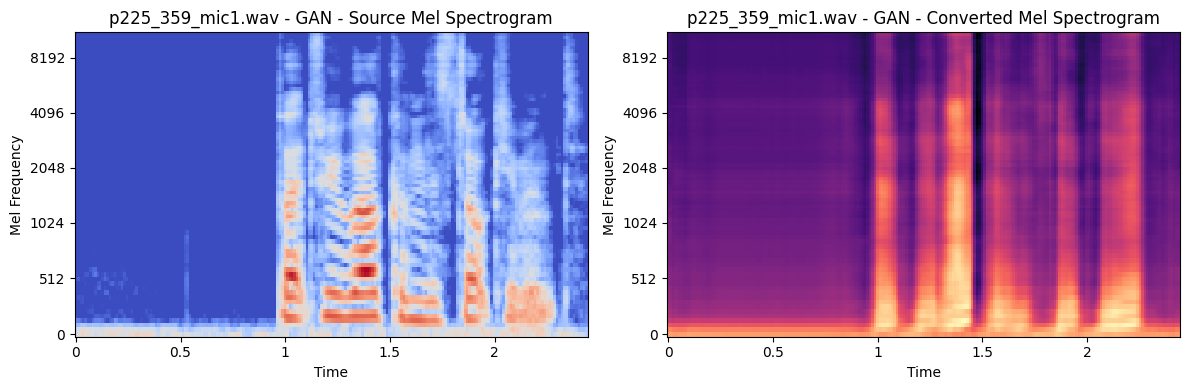


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_365_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_365_mic1.wav


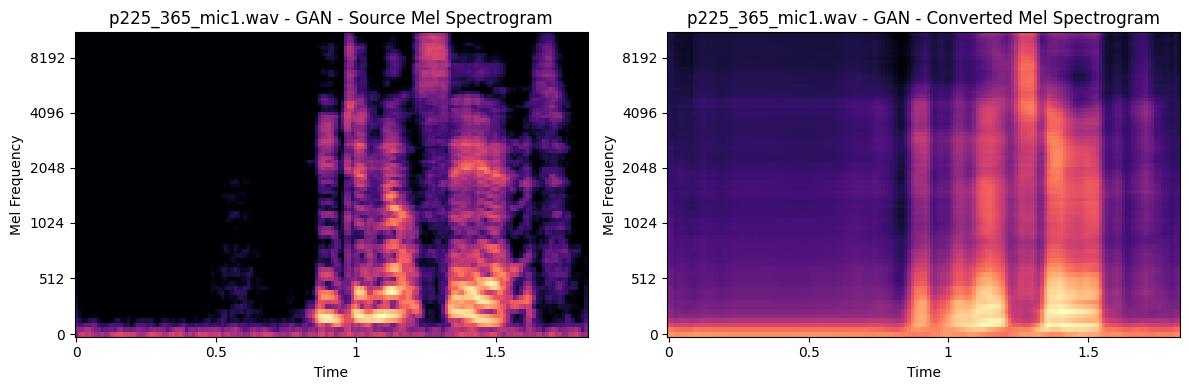


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_363_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_363_mic1.wav


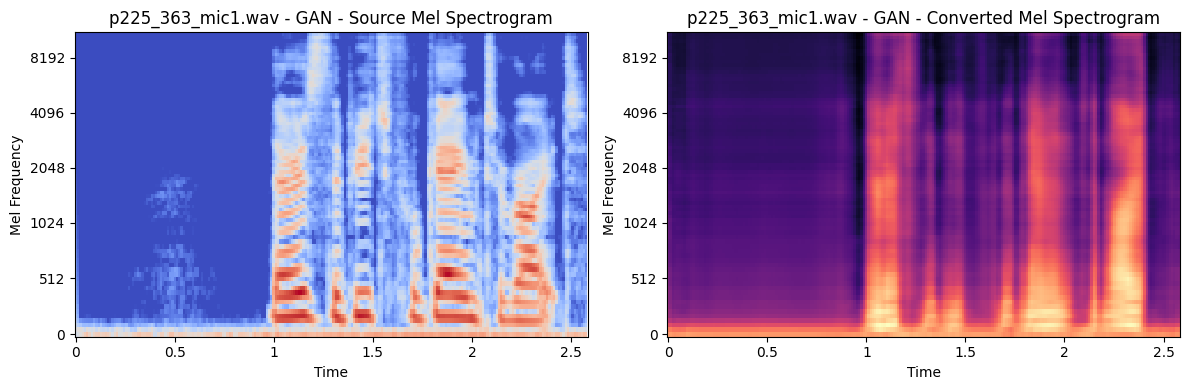


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_366_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_366_mic1.wav


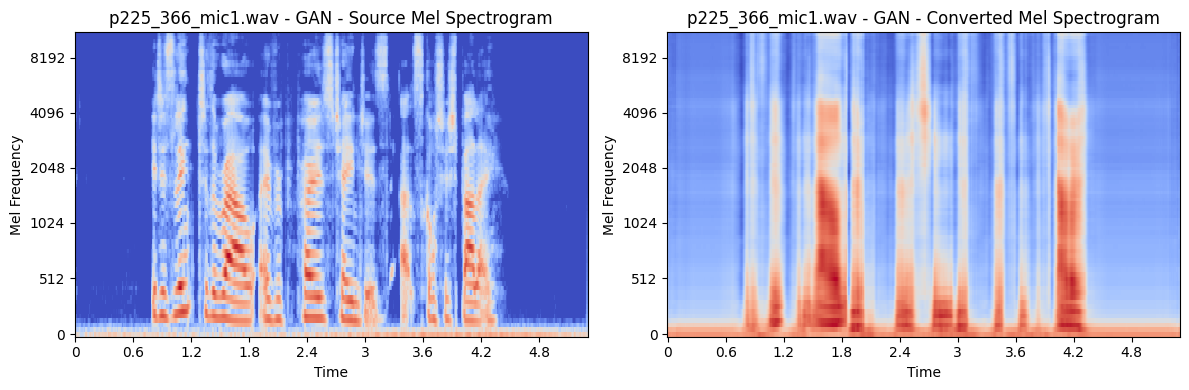


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_358_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_358_mic1.wav


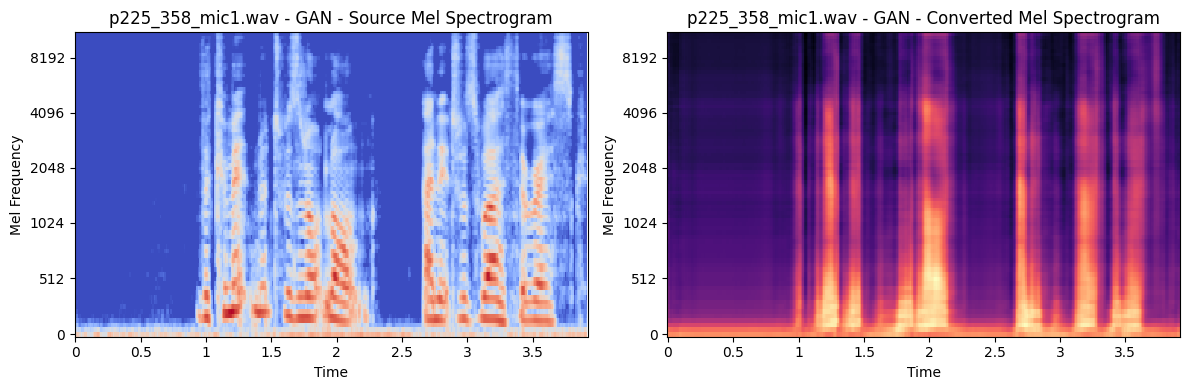


--- Original ---


--- Converted (GAN) ---


Found 5 files to convert
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_359_mic1.wav
[1/5] Converted: p225_359_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_365_mic1.wav
[2/5] Converted: p225_365_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_363_mic1.wav
[3/5] Converted: p225_363_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_366_mic1.wav
[4/5] Converted: p225_366_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_358_mic1.wav
[5/5] Converted: p225_358_mic1.wav


In [ ]:
# inference_vc_gan.py - Inference with GAN-trained model

%matplotlib inline

SR = 22050
HOP = 256
N_FFT = 1024
WIN = 1024
N_MELS = 80
FMIN = 0
FMAX = 8000
device = "cuda" if torch.cuda.is_available() else "cpu"


def load_hifigan_model(checkpoint=GEN_PATH, config=CFG_PATH, device=device):
    """
    Load HiFi-GAN vocoder from checkpoint and config.
    Returns the vocoder model on the requested device.
    """
    import json
    from env import AttrDict
    from models import Generator

    with open(config, "r") as f:
        cfg = json.load(f)
    h = AttrDict(cfg)

    vocoder = Generator(h).to(device)
    state = torch.load(checkpoint, map_location=device)

    # support checkpoints that store {"generator": state_dict} or raw state_dict
    if isinstance(state, dict) and "generator" in state:
        vocoder.load_state_dict(state["generator"])
    else:
        vocoder.load_state_dict(state)

    vocoder.eval()
    # remove weight norm if model defines that method (as in HiFi-GAN)
    if hasattr(vocoder, "remove_weight_norm"):
        vocoder.remove_weight_norm()

    return vocoder

vocoder = load_hifigan_model()

def wav_to_mel(path, sr=22050, n_fft=1024, hop_length=256, n_mels=80):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel = np.log(np.clip(mel, a_min=1e-5, a_max=None))  # log-mel
    mel_tensor = torch.tensor(mel).unsqueeze(0).to(device)  # [1, 80, T]
    return mel_tensor, mel, y

def mel_to_wav(mel, vocoder, sr=SR):
    """
    Convert mel spectrogram to waveform using HiFi-GAN
    mel: numpy (n_mels, T) or torch tensor [1, n_mels, T] or [n_mels, T]
    returns: numpy waveform (float32) normalized to [-1,1]
    """
    if isinstance(mel, np.ndarray):
        if mel.ndim == 2:
            mel_t = torch.from_numpy(mel).unsqueeze(0).float().to(device)
        elif mel.ndim == 3:
            mel_t = torch.from_numpy(mel).float().to(device)
        else:
            raise ValueError("Unexpected mel shape")
    elif isinstance(mel, torch.Tensor):
        mel_t = mel.float().to(device)
        if mel_t.dim() == 2:
            mel_t = mel_t.unsqueeze(0)
    else:
        raise TypeError("mel must be numpy or torch tensor")

    with torch.no_grad():
        audio = vocoder(mel_t).cpu().squeeze().numpy()
    
    # Normalize audio
    audio = audio / (np.max(np.abs(audio)) + 1e-9)
    return audio.astype(np.float32)


def convert_voice(source_path, generator, vocoder, output_path='converted.wav'):
    """
    Main voice conversion function

    Args:
        source_path: path to source audio file
        generator: trained MelMapper model
        vocoder: HiFi-GAN vocoder
        output_path: where to save converted audio

    Returns:
        original_audio, converted_audio, source_mel, converted_mel
    """
    # Load source audio and extract mel
    # wav_to_mel returns (mel_tensor, mel_numpy, waveform)
    mel_tensor, mel_src, y_src = wav_to_mel(source_path)

    # ensure tensor is float and on the correct device
    if isinstance(mel_tensor, torch.Tensor):
        mel_tensor = mel_tensor.float().to(device)
    else:
        mel_tensor = torch.from_numpy(mel_tensor).unsqueeze(0).float().to(device)

    # Apply voice conversion
    generator.eval()
    with torch.no_grad():
        mel_converted = generator(mel_tensor)

    # Convert to waveform
    wav_converted = mel_to_wav(mel_converted, vocoder)

    # Save converted audio
    sf.write(output_path, wav_converted, SR)
    print(f"Converted audio saved to: {output_path}")

    return y_src, wav_converted, mel_src, mel_converted.cpu().numpy()[0]



def visualize_conversion(mel_src, mel_converted, title_prefix=""):
    """Visualize source and converted mel spectrograms"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Source mel
    librosa.display.specshow(mel_src, sr=SR, hop_length=HOP, 
                            x_axis='time', y_axis='mel', ax=axes[0])
    axes[0].set_title(f"{title_prefix}Source Mel Spectrogram")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Mel Frequency")
    
    # Converted mel
    librosa.display.specshow(mel_converted, sr=SR, hop_length=HOP,
                            x_axis='time', y_axis='mel', ax=axes[1])
    axes[1].set_title(f"{title_prefix}Converted Mel Spectrogram")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Mel Frequency")
    
    plt.tight_layout()
    plt.show()

# ==================
# Load trained model
# ==================
generator = MelMapper(n_mels=80, hidden=512).to(device)

# Load checkpoint (use the best performing epoch)
checkpoint_path = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints/generator_epoch40.pt'
generator.load_state_dict(torch.load(checkpoint_path, map_location=device))
generator.eval()

print(f"Loaded generator from: {checkpoint_path}")
print(f"Using device: {device}")

# ==================
# Perform inference
# ==================
import os
from IPython.display import Audio, display

SOURCE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/test'
OUTPUT_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan'
os.makedirs(OUTPUT_DIR, exist_ok=True)

results = []  # to store dictionaries for later use

for fname in os.listdir(SOURCE_DIR):
    if not fname.endswith('.wav'):
        continue

    source_wav = os.path.join(SOURCE_DIR, fname)
    output_wav = os.path.join(OUTPUT_DIR, f'converted_{fname}')

    print(f"\n=== Processing: {fname} ===")

    # Convert using your existing function
    y_orig, wav_converted, mel_orig, mel_converted = convert_voice(
        source_wav,
        generator,
        vocoder,
        output_path=output_wav
    )

    # Save results for later
    results.append({
        "file": fname,
        "y_orig": y_orig,
        "wav_converted": wav_converted,
        "mel_orig": mel_orig,
        "mel_converted": mel_converted,
        "output_wav": output_wav
    })

    # Optional: visualize
    visualize_conversion(mel_orig, mel_converted, title_prefix=f"{fname} - GAN - ")

    # Optional: audio playback
    print("\n--- Original ---")
    display(Audio(y_orig, rate=SR))

    print("--- Converted (GAN) ---")
    display(Audio(wav_converted, rate=SR))


""" # ==================
# Batch processing (optional)
# ==================
def batch_convert(input_folder, output_folder, generator, vocoder):
    Convert all wav files in a folder
    import os
    import glob
    
    os.makedirs(output_folder, exist_ok=True)
    wav_files = glob.glob(os.path.join(input_folder, '*.wav'))
    
    print(f"Found {len(wav_files)} files to convert")
    
    for i, wav_path in enumerate(wav_files):
        basename = os.path.basename(wav_path)
        output_path = os.path.join(output_folder, f"converted_{basename}")
        
        try:
            _, _, _, _ = convert_voice(wav_path, generator, vocoder, output_path)
            print(f"[{i+1}/{len(wav_files)}] Converted: {basename}")
        except Exception as e:
            print(f"[{i+1}/{len(wav_files)}] Failed to convert {basename}: {e}")

# Example batch conversion:
batch_convert(
    '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/test',
    '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted',
    generator,
    vocoder 
)"""